In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pandas as pd
import pyprojroot
import seaborn as sns

In [2]:
RESULTS_ROOT = pyprojroot.here() / 'results'

FIG_ROOT = pyprojroot.here() / 'doc' / 'figures' / 'mainfig_tweetynet_v_svm'
FIG_ROOT.mkdir(exist_ok=True)

In [3]:
data = pd.read_csv(FIG_ROOT / 'fig3-data1.csv')

In [4]:
PALETTE = sns.color_palette('colorblind')  # note: defaults to 10 colors

MODEL_HUE_MAP = {
    'TweetyNet': PALETTE[0],
    'SVM': PALETTE[1],
}

DASHES = {
    'segmented audio, manually cleaned': (4, 1.5),
    'segmented audio, not cleaned': (1, 1),
    'segmented audio, semi-automated cleaning': (3, 1.25, 1.5, 1.25),
    'spectrogram': '',
}

#### actually plot figure

<ipython-input-5-c4b56488fd2f>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_species['train_set_dur_ind'] = data_species['train_set_dur'].map(dur_int_map)


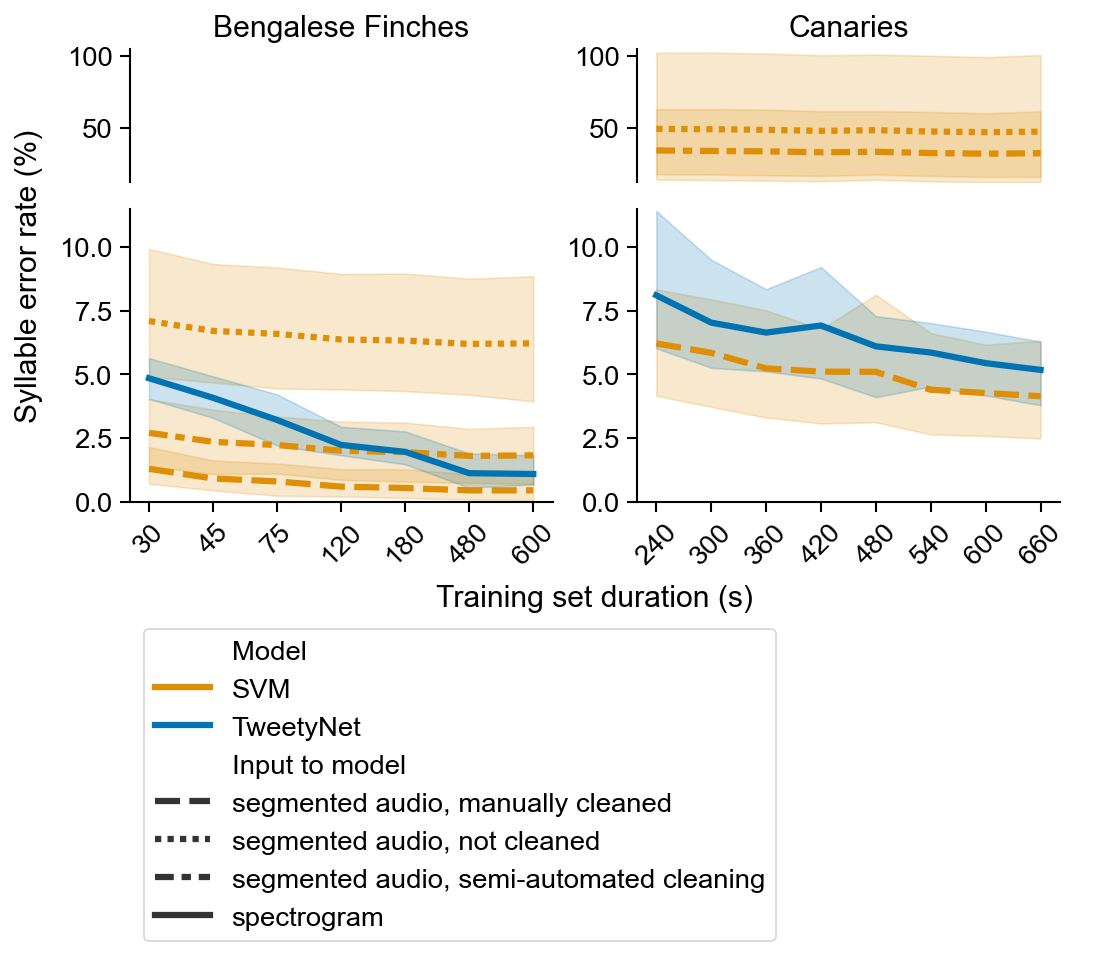

In [5]:
# specify the custom font to use
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'arial'

sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 3})

figsize = (8, 4)
dpi = 150

fig = plt.figure(constrained_layout=False, figsize=figsize, dpi=dpi)

gs = fig.add_gridspec(
    nrows=3, 
    ncols=2, 
)

ax_arr = []
for rows in (
    (0, 1), (1, 3),
):
    start_row, stop_row = rows
    for col in range(2):
        ax_arr.append(fig.add_subplot(gs[start_row:stop_row, col]))

ax_arr = np.array(ax_arr).reshape(2, 2)

MIN_TRAIN_SET_DUR_CANARY = 240

for col, species in enumerate(('Bengalese_Finches', 'Canaries')):
    # ---- get data
    data_species = data[data.Species == species]
    
    if species == 'Canaries':
        data_species = data_species[data_species.train_set_dur >= MIN_TRAIN_SET_DUR_CANARY]

    train_set_durs = sorted(data_species['train_set_dur'].unique())
    dur_int_map = dict(zip(train_set_durs, range(len(train_set_durs))))
    data_species['train_set_dur_ind'] = data_species['train_set_dur'].map(dur_int_map)

    TRAIN_DUR_IND_MAP = {
    k:v for k, v in zip(
        sorted(data_species['train_set_dur'].unique()), 
        sorted(data_species['train_set_dur_ind'].unique())
    )
    }

    svm_mean_seg_err_max_dur = data_species[
        (data_species.Model=='SVM') & (data_species['Input to model'] == 'segmented audio, manually cleaned') & (data_species.train_set_dur ==  data_species.train_set_dur.max())
    ].mean_seg_err.mean()

    tweetynet_mean_seg_err_max_dur = data_species[
        (data_species.Model=='TweetyNet') & (data_species['Input to model'] == 'spectrogram') & (data_species.train_set_dur ==  data_species.train_set_dur.max())
    ].mean_seg_err.mean()
    
    # ---- set up to plot
    col_ax_arr = ax_arr[:, col]

    col_ax_arr[0].get_shared_x_axes().join(col_ax_arr[1])

    # we plot the same data on both axes, and then change the ylims below
    for row, ax in enumerate(col_ax_arr):
        if col == 1 and row == 1:
            # let seaborn generate legend, then we get handles + labels and place under whole figure
            legend = True
        else:
            legend = False

        g = sns.lineplot(
            data=data_species,
            x='train_set_dur_ind',
            y='mean_seg_err',
            hue='Model',
            palette=MODEL_HUE_MAP,
            style='Input to model',
            dashes=DASHES,
            ax=ax,
            legend=legend,
        )

        ax.set_xlabel('')
        ax.set_ylabel('')

        
        if col == 1 and row == 1:
            handles, labels = ax.get_legend_handles_labels()
            g.legend_.remove()

    col_ax_arr[0].set_ylim([12, 105.])
    col_ax_arr[1].set_ylim([0., 11.5])
    
    col_ax_arr[0].set_xticks(list(TRAIN_DUR_IND_MAP.values()))
    col_ax_arr[0].set_xticklabels([])
    col_ax_arr[1].set_xticks(list(TRAIN_DUR_IND_MAP.values()))
    col_ax_arr[1].set_xticklabels(train_set_durs, rotation=45)

    col_ax_arr[0].set_title(species.replace('_', ' '))

# --- despine and fix ticks
for ax_ind, spines, tick_params in zip(
    (0, 1, 2, 3),
    (
        ('top', 'bottom', 'right'),
        ('top', 'bottom', 'right'),
        ('top', 'right',),
        ('top', 'right')
    ),
    (
        dict(axis='x', bottom=False),
        dict(axis='x', bottom=False),
        None,
        None,
    )
):
    for spine in spines:
        ax_arr.flatten()[ax_ind].spines[spine].set_visible(False)
    if tick_params is not None:
        ax_arr.flatten()[ax_ind].tick_params(**tick_params)

# # add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

big_ax.set_xlabel('Training set duration (s)', labelpad=20)
big_ax.set_ylabel('Syllable error rate (%)', labelpad=15)

big_ax.legend(handles, labels, loc='upper left', bbox_to_anchor=[0.0, -0.25])
    
FIG_STEM = 'svm-v-tweetynet-results'
    
for ext in ('png', 'svg'):
    fig.savefig(FIG_ROOT / f'{FIG_STEM}.{ext}', bbox_inches='tight');